In [1]:
import pandas as pd
from NLP_pp import *

raw_data = pd.read_csv('exam_deko.csv')
display(raw_data)

,문서ID,번역,원문(src),번역문(tar)
0,ot_100615,독->한,"mal sehen , ob meine haut reagiert oder nicht .",내 피부가 반응하는지 보자 .
1,ot_100616,독->한,ich habe viele großartige kritiken über drunk ...,저는 드렁크 엘리펀트에 대한 훌륭한 리뷰를 많이 들었습니다 .
2,ot_100617,독->한,lass uns zur poolparty gehen .,수영장 파티에 가자 .
3,ot_100618,독->한,sie bringen einen neuen reiniger auf den markt .,그들은 새로운 청소기를 시장에서 출시하고 있어요 .
4,ot_100619,독->한,genau hier ist nur gepresster gemüsesaft .,바로 여기에 압착 야채 주스가 있어요 .
...,...,...,...,...
120327,md_100608,독->한,"er sucht nach dem ort , der die bewohner verei...","그는 주민들을 결집시킬 수 있는 장소를 찾아다녔고 , 이를 빵집에서 찾는다 ."
120328,md_100609,독->한,"coelho costinha ist ein einfacher mann , der j...",코엘호 코스틴하는 재정적인 어려움을 겪고 있는 평범한 사람이다 .
120329,md_100610,독->한,"als sie aufwacht , ist sie doppelt so alt , de...","그녀가 깨어났을 때 , 그녀는 나이가 두 배나 많이 들었지만 , 여전히 10대처럼 ..."
120330,md_100611,독->한,"viele frauen stecken in der misere , und alle ...","많은 여성들이 불행 속에 살고 있고 , 그들 모두는 그들의 상황에서 벗어날 길을 찾..."


In [2]:
# 인코더의 입력 데이터인 src 데이터
raw_src_data = raw_data['원문(src)'].values.tolist()
# 디코더의 정답지 데이터인 tar 데이터
raw_tar_data = raw_data['번역문(tar)'].values.tolist()

In [3]:
from transformers import BertTokenizer

# 독일어 토크나이저 모델: dbmdz/bert-base-german-uncased
german_tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-german-uncased")
# 한국어 토크나이저 모델: kykim/bert-kor-base
korean_tokenizer = BertTokenizer.from_pretrained("kykim/bert-kor-base")

In [4]:
# 원문 토큰화 수행
tokenized_src_data = tokenize(raw_src_data, german_tokenizer, arch='Bert')
# 번역문 토큰화 수행
tokenized_tar_data = tokenize(raw_tar_data, korean_tokenizer, arch='Bert')

토큰화 진행 중: 100%|██████████| 120332/120332 [00:12<00:00, 9582.80it/s]


In [5]:
from sklearn.model_selection import train_test_split

# 훈련/검증/평가를 80%, 15%, 5%로 분할을 수행
# random_state -> 데이터셋을 내누는데 '재현성' 유지를 위해 넣음 -> 안넣어도 됨
# stratify -> y 클래스 비율을 알기 어렵기에 해당 항목은 없앰
src_train, src_etc, tar_train, tar_etc = train_test_split(
    tokenized_src_data, tokenized_tar_data, test_size=0.20,
    random_state=42
)

# 그 외 데이터셋을 반반으로 Val, Test로 나눔
src_val, src_test, tar_val, tar_test = train_test_split(
    src_etc, tar_etc, test_size=0.25,
    random_state=42
)

In [6]:
from collections import Counter

src_word_list = []
tar_word_list = []
# train항목을 워드 리스트에 입력
for src_sent, tar_sent in zip(src_train, tar_train):
    for word in src_sent:
        src_word_list.append(word)
    for word in tar_sent:
        tar_word_list.append(word)
# val항목을 워드 리스트에 입력
for src_sent, tar_sent in zip(src_train, tar_train):
    for word in src_sent:
        src_word_list.append(word)
    for word in tar_sent:
        tar_word_list.append(word)

# 단어와 해당 단어의 출몰 빈도를 함께 저장하는
# Counter 타입의 변수 생성
src_word_counts = Counter(src_word_list)
tar_word_counts = Counter(tar_word_list)

In [7]:
rare_th = 0 #희소단어의 등장 빈도를 결정하는 파라미터
# 희소단어 등장 빈도를 바탕으로 희소 단어를 배제하기 위해 준비 함수
print(f'---원문(src)에 대한 희소단어 분석---')
src_tot_vocab_cnt, src_rare_vocab_cnt = set_rare_vocab(src_word_counts, rare_th)
print(f'\n---번역문(tar)에 대한 희소단어 분석---')
tar_tot_vocab_cnt, tar_rare_vocab_cnt = set_rare_vocab(tar_word_counts, rare_th)

---원문(src)에 대한 희소단어 분석---

---번역문(tar)에 대한 희소단어 분석---


In [8]:
#등장 빈도가 높은 단어 순으로 정렬하기
src_vocab = sorted(src_word_counts, key=src_word_counts.get, reverse=True)
tar_vocab = sorted(tar_word_counts, key=tar_word_counts.get, reverse=True)

# 원문(src)에 대한 희소단어 배제 & 정렬 작업 수행
src_vocab_size = src_tot_vocab_cnt - src_rare_vocab_cnt
src_vocab = src_vocab[:src_vocab_size]
# 번역문(tar에 대한 희소단어 배제 & 정렬 작업 수행
tar_vocab_size = tar_tot_vocab_cnt - tar_rare_vocab_cnt
tar_vocab = tar_vocab[:tar_vocab_size]

In [9]:
# 스페셜 토큰 선언
spec_token = ['<PAD>', '<UNK>', '<SOS>', '<EOS>']
# 스페셜 토큰을 포함한 {단어:단어idx}의 딕셔너리 생성
print(f'---원문(src)에 대한 단어장 분석---')
src_to_idx, idx_to_src = set_word_to_idx(spec_token, src_vocab, 
                                         report=True)
print(f'\n---번역문(tar)에 대한 단어장 분석---')
tar_to_idx, idx_to_tar = set_word_to_idx(spec_token, tar_vocab, 
                                         report=True)

---원문(src)에 대한 단어장 분석---
단어집합(vocab)은 word_to_idx를 통해서
[단어 : idx]의 <class 'dict'>타입이 되고
스페셜 토큰 <PAD> <UNK> <SOS> <EOS> 을 포함하여
총 관리되는 단어 '22471' -> '22475'가 됨

---번역문(tar)에 대한 단어장 분석---
단어집합(vocab)은 word_to_idx를 통해서
[단어 : idx]의 <class 'dict'>타입이 되고
스페셜 토큰 <PAD> <UNK> <SOS> <EOS> 을 포함하여
총 관리되는 단어 '25697' -> '25701'가 됨


In [10]:
# 원문(src) 데이터셋의 정수 인코딩 수행
e_src_train = text_to_sequences(src_train, src_to_idx)
e_src_val = text_to_sequences(src_val, src_to_idx)
e_src_test = text_to_sequences(src_test, src_to_idx)

# 번역문(tar) 데이터셋의 정수 인코딩 수행
e_tar_train = text_to_sequences(tar_train, tar_to_idx)
e_tar_val = text_to_sequences(tar_val, tar_to_idx)
e_tar_test = text_to_sequences(tar_test, tar_to_idx)

In [11]:
# 번역문(tar)의 접두/접미에 SOS, EOS 토큰 추가
e_tar_train = prefix_suffix_token_insert(e_tar_train, spec_token)
e_tar_val = prefix_suffix_token_insert(e_tar_val, spec_token)
e_tar_test = prefix_suffix_token_insert(e_tar_test, spec_token)

In [12]:
# 원문(src)에 대한 문장패딩 하이퍼 파라미터 설정
src_seq_len = 60
set_sent_pad(e_src_train, src_seq_len)

# 번역문(tar)에 대한 문장패딩 하이퍼 파라미터 설정
tar_seq_len = 55
set_sent_pad(e_tar_train, tar_seq_len)

데이터셋 문장 길이가 60 이하 데이터 비율: 100.00%
데이터셋 문장 길이가 55 이하 데이터 비율: 100.00%


In [13]:
# 원문(src)의 문장 패딩(정수인코딩 완료)
padded_src_train = pad_seq_x(e_src_train, src_seq_len)
padded_src_val = pad_seq_x(e_src_val, src_seq_len)
padded_src_test = pad_seq_x(e_src_test, src_seq_len)

# 번역문(tar)의 문장 패딩(정수인코딩 완료)
padded_tar_train = pad_seq_x(e_tar_train, tar_seq_len)
padded_tar_val = pad_seq_x(e_tar_val, tar_seq_len)
padded_tar_test = pad_seq_x(e_tar_test, tar_seq_len)

In [14]:
print(f'---원문(src) 문장 패딩 결과---')
val_pad_shape(padded_src_train, '훈련')
val_pad_shape(padded_src_val, '검증')
val_pad_shape(padded_src_test, '평가')
print(f'\n---번역문(tar) 문장 패딩 결과---')
val_pad_shape(padded_tar_train, '훈련')
val_pad_shape(padded_tar_val, '검증')
val_pad_shape(padded_tar_test, '평가')

---원문(src) 문장 패딩 결과---
훈련용 정수(원핫)인코딩 shape: (96265, 60)
검증용 정수(원핫)인코딩 shape: (18050, 60)
평가용 정수(원핫)인코딩 shape: (6017, 60)

---번역문(tar) 문장 패딩 결과---
훈련용 정수(원핫)인코딩 shape: (96265, 55)
검증용 정수(원핫)인코딩 shape: (18050, 55)
평가용 정수(원핫)인코딩 shape: (6017, 55)


In [15]:
import torch
bs = 256 # Batch_size 하이퍼 파라미터

# 정수(원핫)인코딩 데이터를 데이터로더로 변환
trainloader = set_dataloader(padded_src_train, padded_tar_train, bs, 
                             content='훈련', report=True)
valloader = set_dataloader(padded_src_val, padded_tar_val, bs,
                           content='검증', report=True)
testloader = set_dataloader(padded_src_test, padded_tar_test, bs, 
                            content='평가', report=True)

훈련용 X(인코딩)데이터 크기: [96265, 60]
훈련용 Y(Label)데이터 크기: [96265, 55]
검증용 X(인코딩)데이터 크기: [18050, 60]
검증용 Y(Label)데이터 크기: [18050, 55]
평가용 X(인코딩)데이터 크기: [6017, 60]
평가용 Y(Label)데이터 크기: [6017, 55]


In [16]:
# 주요 하이퍼 파라미터 정리
src_VS = len(src_to_idx) # 원문 단어장 개수
tar_VS = len(tar_to_idx) # 번역문 단어장 개수
src_SL = src_seq_len # 원문의 문장 길이
# 번역문의 문장 길이를 디코더(생성)문장 길이로 쓰자
tar_SL = tar_seq_len # 번역문 문장 길이

EMB_DIM = 256 # 인코더/디코더의 임베딩 레이어 차원
# unit_dim은 인코더-디코더 사이의 히든레이어처럼 생각하는게 편함
UNIT_DIM = 384 # 인코더와 디코더의 rnn_out 차원값

NUM_Layers = 2 # 인코더/디코더의 셀은 2층으로 만들자
BI_DIR = True # 인코더를 양방향으로 학습

In [17]:
from tabulate import tabulate

# 출력할 데이터를 리스트 형식으로 준비
data = [
    ["원문 단어장 개수", f"{src_VS}개"],
    ["번역문 단어장 개수", f"{tar_VS}개"],
    ["원문 문장 길이", f"{src_SL}토큰"],
    ["번역문 문장 길이", f"{tar_SL}토큰"],
    ["원문/번역문 임베딩 차원", EMB_DIM],
    ["인코더-디코더 연결 차원", UNIT_DIM],
    ["셀 층 개수", f"{NUM_Layers}층"],
    ["양방향/단방향", "인코더 양방향 학습"],
]

# 표 형식으로 출력
print(tabulate(data, tablefmt="grid",
        headers=["하이퍼 파라미터", "값"]))

+-------------------------+--------------------+
| 하이퍼 파라미터         | 값                 |
+=========================+====================+
| 원문 단어장 개수        | 22475개            |
+-------------------------+--------------------+
| 번역문 단어장 개수      | 25701개            |
+-------------------------+--------------------+
| 원문 문장 길이          | 60토큰             |
+-------------------------+--------------------+
| 번역문 문장 길이        | 55토큰             |
+-------------------------+--------------------+
| 원문/번역문 임베딩 차원 | 256                |
+-------------------------+--------------------+
| 인코더-디코더 연결 차원 | 384                |
+-------------------------+--------------------+
| 셀 층 개수              | 2층                |
+-------------------------+--------------------+
| 양방향/단방향           | 인코더 양방향 학습 |
+-------------------------+--------------------+


In [18]:
import torch.nn as nn

class Encoder_LSTM(nn.Module):
    def __init__(self, src_vocab, src_emb_dim, rnn_dim, 
                 num_layer=1, bi=False):
        super(Encoder_LSTM, self).__init__()
        # <PAD>토큰의 인덱싱을 지정하면 해당 idx(0)은
        # word_vector을 만들 때 모두 0으로 채워지게 만들어준다.
        self.embed = nn.Embedding(src_vocab, src_emb_dim,
                                  padding_idx=0)
        self.lstm = nn.LSTM(input_size=src_emb_dim,#언어모델 입력차원
                            hidden_size=rnn_dim,   #언어모델 출력차원
                            num_layers=num_layer,  #언어모델 몇층?
                            bidirectional=bi,      #양방향학습 On?
                            batch_first=True)      #왠만하면 True
    
    def forward(self, x): # x의 차원 : (BS, src_seq_len)
        emb = self.embed(x) # (BS, src_seq_len, src_emb_dim)
        # 인코더에 양방향 학습을 적용한다
        # rnn_out : (bs, src_seq_len, hidden_dim * 2)
        # hidden : (num_layer * 2, bs, hidden_dim)
        rnn_out , (hidden, cell) = self.lstm(emb)
        #인코더의 출력은 context_vector
        return hidden, cell 

In [ ]:
import torch.nn as nn

class Decoder_LSTM(nn.Module):
    def __init__(self, tar_vocab, tar_emb_dim, rnn_dim,
                 num_layer=1, bi=False):
        super(Decoder_LSTM, self).__init__()
        # 양방향으로 인코더가 학습되었으면 hidden_size를 2배로 하기
        self.rnn_dim = rnn_dim * 2 if bi else rnn_dim
        # <PAD>토큰의 인덱싱을 지정하면 해당 idx(0)은
        # word_vector을 만들 때 모두 0으로 채워지게 만들어준다.
        self.embed = nn.Embedding(tar_vocab, tar_emb_dim,
                                  padding_idx=0)
        self.lstm = nn.LSTM(input_size=tar_emb_dim,     #언어모델 입력차원
                            hidden_size=self.rnn_dim,   #언어모델 출력차원
                            num_layers=num_layer,       #언어모델 몇층?
                            bidirectional=False,        #디코더는 항상 단방향
                            batch_first=True)           #왠만하면 True
        
        # 디코더는 인코더가 양방향이면 2배 늘어난 hidden_size가 적용됨
        self.fc = nn.Linear(self.rnn_dim, tar_vocab)
    
    # 디코더는 인코더의 context_vector을 초기 hidden으로 입력받는다.
    def forward(self, x, hidden, cell): # x의 차원 : (BS, tar_seq_len)
        emb = self.embed(x) # (BS, tar_seq_len, tar_emb_dim)
        # 인코더의 양방향 학습이 적용되면 디코더는 아래 차원이 된다.
        # rnn_out : (bs, tar_seq_len, hidden_dim * 2)
        # hidden : (num_layer, bs, hidden_dim * 2)
        rnn_out, (hidden, cell) = self.lstm(emb, (hidden,cell))
        
        output = self.fc(rnn_out)
        # 최종 출력은 (bs, seq_len, tar_vocab)
        return output, hidden, cell

In [20]:
import torch.nn as nn

class Encoder_GRU(nn.Module):
    def __init__(self, src_vocab, src_emb_dim, rnn_dim, 
                 num_layer=1, bi=False):
        super(Encoder_GRU, self).__init__()
        # <PAD>토큰의 인덱싱을 지정하면 해당 idx(0)은
        # word_vector을 만들 때 모두 0으로 채워지게 만들어준다.
        self.embed = nn.Embedding(src_vocab, src_emb_dim,
                                  padding_idx=0)
        self.gru = nn.GRU(input_size=src_emb_dim,#언어모델 입력차원
                            hidden_size=rnn_dim,   #언어모델 출력차원
                            num_layers=num_layer,  #언어모델 몇층?
                            bidirectional=bi,      #양방향학습 On?
                            batch_first=True)      #왠만하면 True
    
    def forward(self, x): # x의 차원 : (BS, src_seq_len)
        emb = self.embed(x) # (BS, src_seq_len, src_emb_dim)
        # 인코더에 양방향 학습을 적용한다
        # rnn_out : (bs, src_seq_len, hidden_dim * 2)
        # hidden : (num_layer * 2, bs, hidden_dim)
        rnn_out , hidden = self.gru(emb)
        #인코더의 출력은 context_vector
        return hidden

In [ ]:
import torch.nn as nn

class Decoder_GRU(nn.Module):
    def __init__(self, tar_vocab, tar_emb_dim, rnn_dim,
                 num_layer=1, bi=False):
        super(Decoder_GRU, self).__init__()
        # 양방향으로 인코더가 학습되었으면 hidden_size를 2배로 하기
        self.rnn_dim = rnn_dim * 2 if bi else rnn_dim
        # <PAD>토큰의 인덱싱을 지정하면 해당 idx(0)은
        # word_vector을 만들 때 모두 0으로 채워지게 만들어준다.
        self.embed = nn.Embedding(tar_vocab, tar_emb_dim,
                                  padding_idx=0)
        self.gru = nn.GRU(input_size=tar_emb_dim,     #언어모델 입력차원
                            hidden_size=self.rnn_dim, #언어모델 출력차원
                            num_layers=num_layer,     #언어모델 몇층?
                            bidirectional=False,      #디코더는 항상 단방향
                            batch_first=True)         #왠만하면 True
        
        # 디코더는 인코더가 양방향이면 2배 늘어난 hidden_size가 적용됨
        self.fc = nn.Linear(self.rnn_dim, tar_vocab)
    
    # 디코더는 인코더의 context_vector을 초기 hidden으로 입력받는다.
    def forward(self, x, hidden): # x의 차원 : (BS, tar_seq_len)
        emb = self.embed(x) # (BS, tar_seq_len, tar_emb_dim)
        # 인코더의 양방향 학습이 적용되면 디코더는 아래 차원이 된다.
        # rnn_out : (bs, tar_seq_len, hidden_dim * 2)
        # hidden : (num_layer, bs, hidden_dim * 2)
        rnn_out, hidden = self.gru(emb, hidden)
        
        output = self.fc(rnn_out)
        # 최종 출력은 (bs, seq_len, tar_vocab)
        return output, hidden

In [ ]:
import torch
import torch.nn as nn

class Peeky_Seq2Seq_LSTM(nn.Module):
    def __init__(self, encoder, decoder, spec_token, 
                        max_len=None, bi=False):
        super(Peeky_Seq2Seq_LSTM, self).__init__()
        self.encode = encoder
        self.decode = decoder
        
        self.max_len = max_len  # 최대 디코딩 길이 설정
        self.spec_token = spec_token    # 스페셜 토큰 정보 입력
        self.Bi = bi # 인코더가 양방향/단방향 학습인지 확인

        if self.Bi: #인코더가 양방향인경우
            # 인코더의 context vector 사이즈는 hidden_size의 2배가 됨
            CV_size = encoder.lstm.hidden_size * 2
        else: #인코더가 단방향인경우
            CV_size = encoder.lstm.hidden_size
        # 디코더의 hid_dim 사이즈 정보 추출
        DH_size = decoder.lstm.hidden_size

        self.peeky_h = nn.Sequential(
            nn.Linear(CV_size + DH_size, DH_size),
            nn.Tanh())
        self.peeky_c = nn.Sequential(
            nn.Linear(CV_size + DH_size, DH_size),
            nn.Tanh())

    def _reshape_Bi_context_vector(self, context_vector):
        # 인코더가 양방향 학습이면 차원이 (nL*2, BS, hid_dim)이다.
        # 이를 (nl, BS, hid_dim*2)로 변경해줘야한다.
        nL, BS, hid_dim = context_vector.size()
        nL = nL // 2 #현재 num_layers는 nl*2이니 반갈죽
        # 코드 가독성을 위해 차원변환이 되는 과정을 두개로 나눔
        temp = context_vector.view(nL, 2, BS, hid_dim)
        re_CV = temp.transpose(1, 2).reshape(nL, BS, -1)
        # 최종차원은 (nl, BS, hid_dim*2)
        return re_CV
    
    def _update_hidden_with_peeky(self, context_h, context_c, h, c):
        # 디코더의 hidden_state에 인코더 context_vector을 Peeky하기
        concat_h = torch.cat((context_h, h), dim=-1) # 입력 전 합치기
        concat_c = torch.cat((context_c, c), dim=-1) # 입력 전 합치기
        h = self.peeky_h(concat_h) # 합친 정보로 업데이트하기
        c = self.peeky_c(concat_c)
        return h, c

    def forward(self, src, tar=None, TF_ratio=1):
        # 인코더의 출력 = context_vector
        context_h, context_c = self.encode(src)
        if self.Bi : #양방향 학습인 경우 -> 차원변환이 필요함
            context_h = self._reshape_Bi_context_vector(context_h)
            context_c = self._reshape_Bi_context_vector(context_c)

        # 스페셜 토큰에서 SOS, EOS, PAD의 정수인코딩값 추출
        en_sos = self.spec_token.index('<SOS>')
        en_eos = self.spec_token.index('<EOS>')
        en_pad = self.spec_token.index('<PAD>')

        if tar is not None:
            # 배치사이즈, 연산위치 정보 추출(tar 기준으로)
            BS, tar_seq_len = tar.size() 
            device = tar.device

            # 디코더의 첫번째 토큰을 <SOS>에 (BS, 1)차원으로 생성
            # 이때 정답지(tar)의 맨 앞토큰은 <SOS>로 채워져 있으니 이를 이용한다.
            input_token = tar[:, 0].unsqueeze(1)
            outputs = [] # 출력 디코드 결과를 저장

            # 임의 난수를 (BS)차원으로 생성 후 TF_ratio비율정보를 받아서
            # 마스크 플래그로 변환, 이때 TF_ratio는 0~1 사이값
            # 1에 가까울수록 대부분의 Flag는 True가 되서 지도학습비율이 올라감
            TF_flag = torch.rand(BS, device=device) < TF_ratio

            # 초기 은닉상태 설정
            h, c = context_h, context_c

            # tar seq는 맨 처음 토큰을 <SOS>로 채웟으니 1번부터 시작
            for t in range(1, tar_seq_len):
                # 토큰단위로 입력이니 출력은 (bs, 1, tar_vocab)이다.
                out_tokens, h, c = self.decode(input_token, h, c)
                outputs.append(out_tokens)

                # 디코더의 hidden_state에 인코더 context_vector을 Peeky하기
                h, c = self._update_hidden_with_peeky(context_h, context_c, h, c)

                # 마스크 플래그가 True : 지도학습 방식으로 동작
                # 마스크 플래그가 False : 비지도학습-자가 회귀방식으로 동작
                input_token = torch.where(TF_flag.unsqueeze(1), 
                                            tar[:, t].unsqueeze(1),
                                            out_tokens.argmax(dim=-1))

            # 최종 출력 모양 조정 
            outputs = torch.cat(outputs, dim=1) # (BS, tar_seq_len-1, tar_vocab)
            # (BS, 1, tar_vocab) 차원의 sos 토큰 인덱스로 채워진 텐서를 만듬
            sos_tokens = torch.full((BS, 1, outputs.size(-1)), en_sos, device=device)
            # sos_tokens랑 outputs를 합쳐서 (BS, tar_seq_len, tar_vocab)가 되게 함
            outputs = torch.cat([sos_tokens, outputs], dim=1)
            return outputs # (BS, tar_seq_len, tar_vocab)
        
        else: # 정답지가 없는 평가모드
            # 배치사이즈, 연산위치 정보 추출(src 기준으로)
            BS, src_seq_len = src.size() 
            device = src.device
            # 최대 디코딩 길이 지정 안했으면 원문 seq_len을 쓰자
            if self.max_len is None:
                self.max_len = src_seq_len

            # 디코더의 첫번째 토큰을 <SOS>에 (BS, 1)차원으로 생성
            input_token = torch.tensor([[en_sos]] * BS).to(device)
            outputs = [] # 출력 디코드 결과를 저장

            # EOS를 샘플별로 예측하면 그 뒷단을 PAD로 채우는 flag 텐서
            pad_mask_flag = torch.zeros(BS, dtype=torch.bool, 
                                        device=device)
            # 만약에 Batch내 샘플이 <EOS>예측했다면 해당 샘플의 flag가 올라간다.

            # 토큰 단위로 예측이니 자가 회귀 방식임
            h, c = context_h, context_c

            for _ in range(self.max_len):
                # 토큰단위로 입력이니 출력은 (bs, 1, tar_vocab)이다.
                out_tokens, h, c = self.decode(input_token, h, c)

                # 추론 과정이니 next_token은
                # Greedy Search-> (bs, 1)결과가 됨
                next_token = out_tokens.argmax(dim=-1)
                outputs.append(next_token)

                # 디코더의 hidden_state에 인코더 context_vector을 Peeky하기
                h, c = self._update_hidden_with_peeky(context_h, context_c, h, c)

                # 배치 내 샘플이 <EOS>토큰을 예측한다면 해당샘플의 flag를 True로 올린다.
                # 이때 next_token = (bs, 1) -> (bs)로 차원 축소 후 인디케이터 연산해야함
                eos_indices = (next_token.squeeze(1) == en_eos)
                # OR연산이니까 EOS예측된 마스크는 계속 True로 남는다.
                pad_mask_flag = pad_mask_flag | eos_indices

                # 모든 샘플에서 EOS를 예측한 경우, 더이상 수행하지 않고 탈출
                if pad_mask_flag.all():
                    break

                # 자가 회귀방식이니 다음 입력을 갱신한다.
                input_token = torch.where(pad_mask_flag.unsqueeze(1), 
                                          torch.full_like(next_token, en_pad), 
                                          next_token)
            
            # 예측된 단어들을 모아서 최종 출력으로 반환
            # 이때 최종 출력은 # (BS, max_len) 규격을 맞추기 위해
            # PAD토큰을 채우는 과정을 수행한다.
            while len(outputs) < self.max_len:
                outputs.append(torch.full((BS, 1), en_pad, 
                                          device=device))

            outputs = torch.cat(outputs, dim=1)  # (BS, max_len)
            return outputs

In [23]:
import torch
import torch.nn as nn

class Peeky_Seq2Seq_GRU(nn.Module):
    def __init__(self, encoder, decoder, spec_token, 
                 max_len=None, bi=False):
        super(Peeky_Seq2Seq_GRU, self).__init__()
        self.encode = encoder
        self.decode = decoder
        
        self.max_len = max_len  # 최대 디코딩 길이 설정
        self.spec_token = spec_token    # 스페셜 토큰 정보 입력
        self.Bi = bi # 인코더가 양방향/단방향 학습인지 확인

        if self.Bi: #인코더가 양방향인경우
            # 인코더의 context vector 사이즈는 hidden_size의 2배가 됨
            CV_size = encoder.gru.hidden_size * 2
        else: #인코더가 단방향인경우
            CV_size = encoder.gru.hidden_size
        # 디코더의 hid_dim 사이즈 정보 추출
        DH_size = decoder.gru.hidden_size

        self.peeky_h = nn.Sequential(
            nn.Linear(CV_size + DH_size, DH_size),
            nn.Tanh())
        
    def _reshape_Bi_context_vector(self, context_vector):
        # 인코더가 양방향 학습이면 차원이 (nL*2, BS, hid_dim)이다.
        # 이를 (nl, BS, hid_dim*2)로 변경해줘야한다.
        nL, BS, hid_dim = context_vector.size()
        nL = nL // 2 #현재 num_layers는 nl*2이니 반갈죽
        # 코드 가독성을 위해 차원변환이 되는 과정을 두개로 나눔
        temp = context_vector.view(nL, 2, BS, hid_dim)
        re_CV = temp.transpose(1, 2).reshape(nL, BS, -1)
        # 최종차원은 (nl, BS, hid_dim*2)
        return re_CV
    
    def _update_hidden_with_peeky(self, context_h, h):
        # 디코더의 hidden_state에 인코더 context_vector을 Peeky하기
        concat_h = torch.cat((context_h, h), dim=-1) # 입력 전 합치기
        h = self.peeky_h(concat_h) # 합친 정보로 업데이트하기
        return h

    def forward(self, src, tar=None, TF_ratio=1):
        # 인코더의 출력 = context_vector
        context_h = self.encode(src)
        if self.Bi : #양방향 학습인 경우 -> 차원변환이 필요함
            context_h = self._reshape_Bi_context_vector(context_h)

        # 스페셜 토큰에서 SOS, EOS, PAD의 정수인코딩값 추출
        en_sos = self.spec_token.index('<SOS>')
        en_eos = self.spec_token.index('<EOS>')
        en_pad = self.spec_token.index('<PAD>')

        if tar is not None:
            # 배치사이즈, 연산위치 정보 추출(tar 기준으로)
            BS, tar_seq_len = tar.size() 
            device = tar.device

            # 디코더의 첫번째 토큰을 <SOS>에 (BS, 1)차원으로 생성
            # 이때 정답지(tar)의 맨 앞토큰은 <SOS>로 채워져 있으니 이를 이용한다.
            input_token = tar[:, 0].unsqueeze(1)
            outputs = [] # 출력 디코드 결과를 저장

            # 임의 난수를 (BS)차원으로 생성 후 TF_ratio비율정보를 받아서
            # 마스크 플래그로 변환, 이때 TF_ratio는 0~1 사이값
            # 1에 가까울수록 대부분의 Flag는 True가 되서 지도학습비율이 올라감
            TF_flag = torch.rand(BS, device=device) < TF_ratio

            # 초기 은닉상태 설정
            h = context_h

            # tar seq는 맨 처음 토큰을 <SOS>로 채웟으니 1번부터 시작
            for t in range(1, tar_seq_len):
                # 토큰단위로 입력이니 출력은 (bs, 1, tar_vocab)이다.
                out_tokens, h = self.decode(input_token, h)
                outputs.append(out_tokens)

                # 디코더의 hidden_state에 인코더 context_vector을 Peeky하기
                h = self._update_hidden_with_peeky(context_h, h)

                # 마스크 플래그가 True : 지도학습 방식으로 동작
                # 마스크 플래그가 False : 비지도학습-자가 회귀방식으로 동작
                input_token = torch.where(TF_flag.unsqueeze(1), 
                                            tar[:, t].unsqueeze(1),
                                            out_tokens.argmax(dim=-1))

            # 최종 출력 모양 조정 
            outputs = torch.cat(outputs, dim=1) # (BS, tar_seq_len-1, tar_vocab)
            # (BS, 1, tar_vocab) 차원의 sos 토큰 인덱스로 채워진 텐서를 만듬
            sos_tokens = torch.full((BS, 1, outputs.size(-1)), en_sos, device=device)
            # sos_tokens랑 outputs를 합쳐서 (BS, tar_seq_len, tar_vocab)가 되게 함
            outputs = torch.cat([sos_tokens, outputs], dim=1)
            return outputs # (BS, tar_seq_len, tar_vocab)
        
        else: # 정답지가 없는 평가모드
            # 배치사이즈, 연산위치 정보 추출(src 기준으로)
            BS, src_seq_len = src.size() 
            device = src.device
            # 최대 디코딩 길이 지정 안했으면 원문 seq_len을 쓰자
            if self.max_len is None:
                self.max_len = src_seq_len

            # 디코더의 첫번째 토큰을 <SOS>에 (BS, 1)차원으로 생성
            input_token = torch.tensor([[en_sos]] * BS).to(device)
            outputs = [] # 출력 디코드 결과를 저장

            # EOS를 샘플별로 예측하면 그 뒷단을 PAD로 채우는 flag 텐서
            pad_mask_flag = torch.zeros(BS, dtype=torch.bool, 
                                        device=device)
            # 만약에 Batch내 샘플이 <EOS>예측했다면 해당 샘플의 flag가 올라간다.

            # 토큰 단위로 예측이니 자가 회귀 방식임
            h = context_h

            for _ in range(self.max_len):
                # 토큰단위로 입력이니 출력은 (bs, 1, tar_vocab)이다.
                out_tokens, h = self.decode(input_token, h)

                # 추론 과정이니 next_token은
                # Greedy Search-> (bs, 1)결과가 됨
                next_token = out_tokens.argmax(dim=-1)
                outputs.append(next_token)

                # 디코더의 hidden_state에 인코더 context_vector을 Peeky하기
                h = self._update_hidden_with_peeky(context_h, h)

                # 배치 내 샘플이 <EOS>토큰을 예측한다면 해당샘플의 flag를 True로 올린다.
                # 이때 next_token = (bs, 1) -> (bs)로 차원 축소 후 인디케이터 연산해야함
                eos_indices = (next_token.squeeze(1) == en_eos)
                # OR연산이니까 EOS예측된 마스크는 계속 True로 남는다.
                pad_mask_flag = pad_mask_flag | eos_indices

                # 모든 샘플에서 EOS를 예측한 경우, 더이상 수행하지 않고 탈출
                if pad_mask_flag.all():
                    break

                # 자가 회귀방식이니 다음 입력을 갱신한다.
                input_token = torch.where(pad_mask_flag.unsqueeze(1), 
                                          torch.full_like(next_token, en_pad), 
                                          next_token)
            
            # 예측된 단어들을 모아서 최종 출력으로 반환
            # 이때 최종 출력은 # (BS, max_len) 규격을 맞추기 위해
            # PAD토큰을 채우는 과정을 수행한다.
            while len(outputs) < self.max_len:
                outputs.append(torch.full((BS, 1), en_pad, 
                                          device=device))

            outputs = torch.cat(outputs, dim=1)  # (BS, max_len)
            return outputs

In [24]:
# 학습 실험 조건을 구분하기 위한 키
model_key = ['LSTM', 'GRU']
metrics_key = ['Loss', '정확도']

In [25]:
# Seq2Seq의 LSTM버전 인스턴스화
encoder_lstm = Encoder_LSTM(src_VS, EMB_DIM, UNIT_DIM, 
                            num_layer=NUM_Layers, bi=BI_DIR)
decoder_lstm = Decoder_LSTM(tar_VS, EMB_DIM, UNIT_DIM,
                            num_layer=NUM_Layers, bi=BI_DIR)
Translater_lstm = Peeky_Seq2Seq_LSTM(encoder_lstm, decoder_lstm, 
                    spec_token=spec_token, max_len=tar_SL, bi=BI_DIR)

# Seq2Seq의 GRU버전 인스턴스화
encoder_gru = Encoder_GRU(src_VS, EMB_DIM, UNIT_DIM, 
                            num_layer=NUM_Layers, bi=BI_DIR)
decoder_gru = Decoder_GRU(tar_VS, EMB_DIM, UNIT_DIM,
                            num_layer=NUM_Layers, bi=BI_DIR)
Translater_gru = Peeky_Seq2Seq_GRU(encoder_gru, decoder_gru, 
                    spec_token=spec_token, max_len=tar_SL, bi=BI_DIR)

In [26]:
# GPU사용 가능 유/무 확인
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
models = {} # 딕셔너리

models[model_key[0]] = Translater_lstm.to(device)
models[model_key[1]] = Translater_gru.to(device)

In [27]:
import torch.optim as optim
# 로스함수 및 옵티마이저 설계
# 로스함수에서 <PAD> 토큰의 정수인덱스 번호 -> 0번에 대해서는
# 틀리건 맞건 무시하겠다 : ignore_index에 해당 정수 인덱스 번호 기입
ignore_class_idx = spec_token.index('<PAD>')
criterion = nn.CrossEntropyLoss(ignore_index=ignore_class_idx)

LR = 0.001 # 러닝레이트는 통일
optimizers = {}

optimizers[model_key[0]] = optim.Adam(Translater_lstm.parameters(), lr=LR)
optimizers[model_key[1]] = optim.Adam(Translater_gru.parameters(), lr=LR)

In [43]:
from Seq_trainer import *

num_epoch = 35 #총 훈련/검증 epoch값
ES = 7 # 디스플레이용 에포크 스텝

# Techer forcing 비율을 스케줄러 형식으로 조정하기 위한 클래스 객체화
TF_ratio = 1.0
TF_schedular = TeacherForcingScheduler(TF_ratio, 
                                       Damping_Factor=0.95,
                                       min_TF= 0.35)

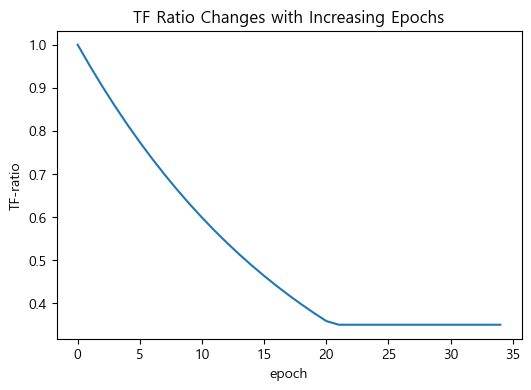

In [44]:
TF_schedular.demo(num_epoch)

In [29]:
# 학습/검증 정보 저장
history = {key: {metric: [] 
                for metric in metrics_key} 
           for key in model_key}

In [30]:
for key in model_key:
    print(f"\n--현재 훈련중인 조건: [Peeky_Seq2Seq_{key}]--") # 조건에 맞는 실험시작
    for epoch in range(num_epoch): #에포크별 모델 훈련/검증
        # 모델 훈련
        train_loss, train_acc = model_train(
            models[key], trainloader, criterion,
            optimizers[key], epoch, ES,
            ignore_class=ignore_class_idx, #무시할 클래스 인덱스
            TF_schedular=None #Techer forcing비율 조정 함수
        ) 
        #모델 검증
        val_loss, val_acc = model_evaluate(
            models[key], valloader, criterion,
            epoch, ES, 
            ignore_class=ignore_class_idx, #무시할 클래스 인덱스
        )

        # 손실 및 성과 지표를 history에 저장
        history[key]['Loss'].append((train_loss, val_loss))
        history[key]['정확도'].append((train_acc, val_acc))

        # Epoch_step(ES)일 때마다 print수행
        if (epoch+1) % ES == 0 or epoch == 0:
            print(f"epoch {epoch+1:03d}," + "\t" + 
                f"훈련 [Loss: {train_loss:.3f}, " +
                f"Acc: {train_acc*100:.2f}%]")
            print(f"epoch {epoch+1:03d}," + "\t" + 
                f"검증 [Loss: {val_loss:.3f}, " +
                f"Acc: {val_acc*100:.2f}%]")
    print(f"--[Peeky_Seq2Seq_{key}] 훈련 종료--\n") # 조건에 맞는 실험종료


--현재 훈련중인 조건: [Peeky_Seq2Seq_LSTM]--


100%|██████████| 71/71 [00:04<00:00, 16.18it/s]


epoch 001,	훈련 [Loss: 7.008, Acc: 16.28%]
epoch 001,	검증 [Loss: 8.909, Acc: 6.60%]


100%|██████████| 71/71 [00:04<00:00, 16.32it/s]


epoch 007,	훈련 [Loss: 3.245, Acc: 45.16%]
epoch 007,	검증 [Loss: 9.884, Acc: 8.02%]


100%|██████████| 71/71 [00:04<00:00, 16.26it/s]


epoch 014,	훈련 [Loss: 1.433, Acc: 78.54%]
epoch 014,	검증 [Loss: 11.903, Acc: 7.70%]


100%|██████████| 71/71 [00:04<00:00, 16.27it/s]


epoch 021,	훈련 [Loss: 0.807, Acc: 91.87%]
epoch 021,	검증 [Loss: 13.975, Acc: 7.22%]


100%|██████████| 71/71 [00:04<00:00, 16.17it/s]


epoch 028,	훈련 [Loss: 0.683, Acc: 93.55%]
epoch 028,	검증 [Loss: 15.275, Acc: 7.54%]


100%|██████████| 71/71 [00:04<00:00, 16.42it/s]


epoch 035,	훈련 [Loss: 0.646, Acc: 93.68%]
epoch 035,	검증 [Loss: 16.115, Acc: 7.65%]
--[Peeky_Seq2Seq_LSTM] 훈련 종료--


--현재 훈련중인 조건: [Peeky_Seq2Seq_GRU]--


100%|██████████| 71/71 [00:04<00:00, 17.52it/s]


epoch 001,	훈련 [Loss: 6.705, Acc: 18.95%]
epoch 001,	검증 [Loss: 9.345, Acc: 5.91%]


100%|██████████| 71/71 [00:04<00:00, 17.64it/s]


epoch 007,	훈련 [Loss: 2.983, Acc: 47.48%]
epoch 007,	검증 [Loss: 10.334, Acc: 7.81%]


100%|██████████| 71/71 [00:04<00:00, 17.42it/s]


epoch 014,	훈련 [Loss: 1.262, Acc: 81.12%]
epoch 014,	검증 [Loss: 12.733, Acc: 6.77%]


100%|██████████| 71/71 [00:04<00:00, 17.51it/s]


epoch 021,	훈련 [Loss: 0.862, Acc: 89.27%]
epoch 021,	검증 [Loss: 15.188, Acc: 6.96%]


100%|██████████| 71/71 [00:04<00:00, 15.99it/s]


epoch 028,	훈련 [Loss: 0.793, Acc: 90.22%]
epoch 028,	검증 [Loss: 16.810, Acc: 6.80%]


100%|██████████| 71/71 [00:04<00:00, 17.52it/s]

epoch 035,	훈련 [Loss: 0.764, Acc: 90.72%]
epoch 035,	검증 [Loss: 17.920, Acc: 6.48%]
--[Peeky_Seq2Seq_GRU] 훈련 종료--



In [31]:
import matplotlib.pyplot as plt
# 한글 사용을 위한 폰트 포함
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [32]:
# 학습/검증 결과 데이터를 재배치
res_data = {}

for key in model_key:
    res_data[key] = {}
    for metric in metrics_key:
        # 각 모델의 메트릭 데이터 추출
        metric_data = history[key][metric]
        # 훈련 및 검증 값 분리
        train_values = [tup[0] for tup in metric_data]
        val_values = [tup[1] for tup in metric_data]
        res_data[key][f'훈련_{metric}'] = train_values
        res_data[key][f'검증_{metric}'] = val_values

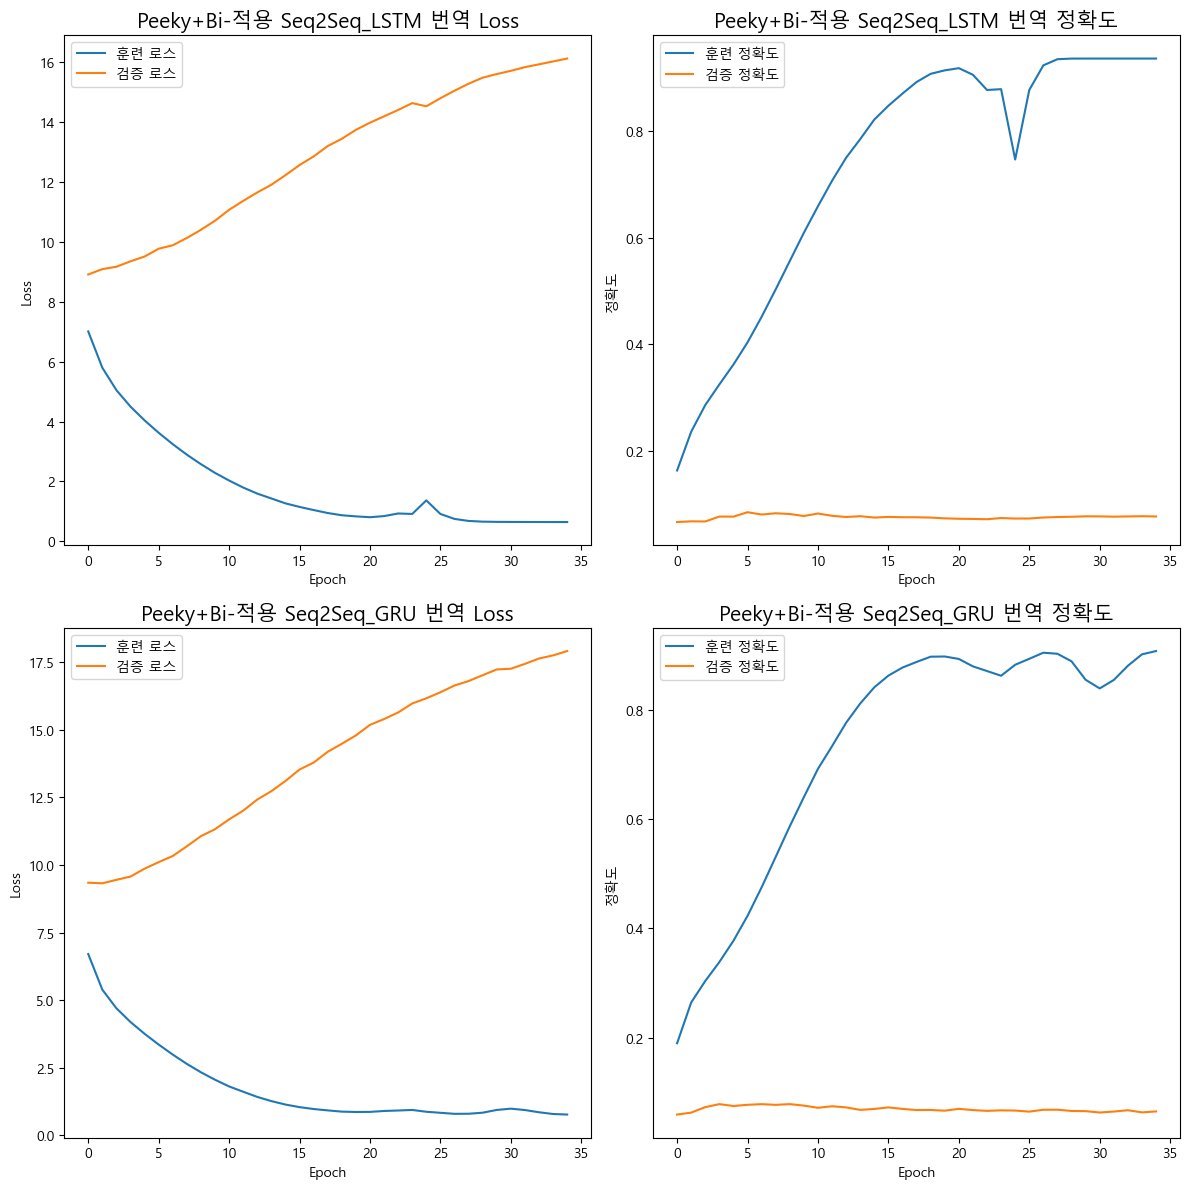

In [33]:
# 손실 및 정확도 그래프 그리기 그래프 생성
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()  # 2차원 배열을 1차원으로 변환하여 인덱싱 쉽게 함

# 손실 그래프 그리기
for idx, key in enumerate(model_key):
    ax = axes[idx*2] #손실 그래프는 0, 2번째에 위치
    ax.plot(res_data[key]['훈련_Loss'], label='훈련 로스')
    ax.plot(res_data[key]['검증_Loss'], label='검증 로스')

    ax.set_title(f'Peeky+Bi-적용 Seq2Seq_{key} 번역 Loss', fontsize=15)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

# 정확도 그래프 그리기
for idx, key in enumerate(model_key):
    ax = axes[idx*2 + 1] #정확도 그래프는 1, 3번째에 위치
    ax.plot(res_data[key]['훈련_정확도'], label='훈련 정확도')
    ax.plot(res_data[key]['검증_정확도'], label='검증 정확도')
    ax.set_title(f'Peeky+Bi-적용 Seq2Seq_{key} 번역 정확도', fontsize=15)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('정확도')
    ax.legend()


plt.tight_layout()
plt.show()

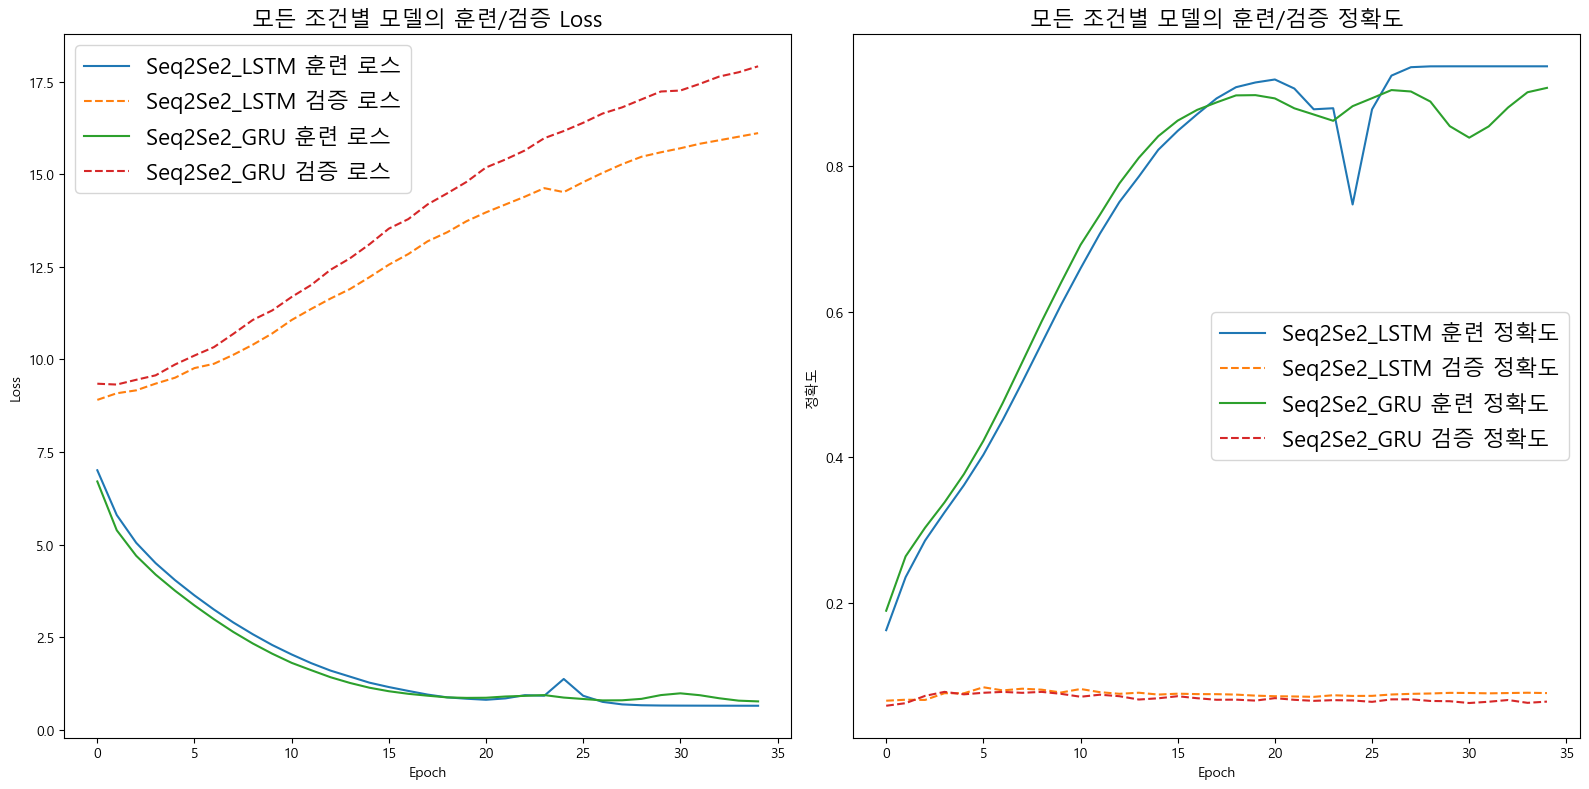

In [34]:
# 모든 모델의 손실과 정확도를 비교하는 그래프 생성
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 모든 모델의 손실 그래프
ax = axes[0]
for key in model_key:
    ax.plot(res_data[key]['훈련_Loss'], label=f'Seq2Se2_{key} 훈련 로스')
    ax.plot(res_data[key]['검증_Loss'], label=f'Seq2Se2_{key} 검증 로스', linestyle='--')
ax.set_title('모든 조건별 모델의 훈련/검증 Loss', fontsize=16)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(fontsize=16)  # 범례의 폰트 크기 설정

# 모든 모델의 정확도 그래프
ax = axes[1]
for key in model_key:
    ax.plot(res_data[key]['훈련_정확도'], label=f'Seq2Se2_{key} 훈련 정확도')
    ax.plot(res_data[key]['검증_정확도'], label=f'Seq2Se2_{key} 검증 정확도', linestyle='--')
ax.set_title('모든 조건별 모델의 훈련/검증 정확도', fontsize=16)
ax.set_xlabel('Epoch')
ax.set_ylabel('정확도')
ax.legend(fontsize=16)  # 범례의 폰트 크기 설정

plt.tight_layout()
plt.show()

In [35]:
# 학습된 모델 저장
path = {} #모델별 경로명 저장
for mk in model_key:
    path[mk] = f'Peeky_Seq2Seq_{mk}.pth'
    torch.save(models[mk].state_dict(), path[mk])

In [36]:
# 저장된 모델 불러오기
load_model = {
    'LSTM': Translater_lstm,  # LSTM 모델 인스턴스 생성
    'GRU': Translater_gru     # GRU 모델 인스턴스 생성
}
for mk in model_key:
    load_model[mk].load_state_dict(torch.load(path[mk], weights_only=True))
    #추론기는 CPU에서 돌리자
    load_model[mk] = load_model[mk].to('cpu')

In [37]:
import random
# 테스트 데이터셋에서 샘플을 추출
# 전체 테스트 데이터 개수정보를 추출
num_test = padded_src_test.shape[0]
sample_epoch = 10 #추출할 샘플 개수 정의
indices = random.sample(range(num_test), sample_epoch)

# 추출한 샘플번호를 바탕으로 Test 데이터셋에서 무작위 추출
S_src_test = padded_src_test[indices]
S_tar_test = padded_tar_test[indices]

# 원문 데이터만 텐서 자료형으로 변환
TS_src_test = torch.tensor(S_src_test, dtype=torch.long)

In [39]:
from Seq_trainer import *

# 추론 결과를 저장할 딕셔너리
tar_dict = {key: []  for key in model_key}

for key in model_key:
    print(f"\n--현재 추론 조건: [Seq2Seq_{key}]--") # 조건에 맞는 실험시작
    for idx in tqdm(range(sample_epoch)): #추론 에포크별 추론 시작
        # 입력되는 원문 차원을 (1, src_seq_len)으로 만들기 위한 코드
        iter_src_data = TS_src_test[idx].unsqueeze(0)
        # 모델 추론 -> 추론결과는 (bs, max_len) ndarray타입임
        tar_infer_doc = model_inference(load_model[key], iter_src_data)
        tar_dict[key].append(tar_infer_doc)


--현재 추론 조건: [Seq2Seq_LSTM]--


100%|██████████| 10/10 [00:01<00:00,  7.50it/s]



--현재 추론 조건: [Seq2Seq_GRU]--


100%|██████████| 10/10 [00:01<00:00,  9.25it/s]


In [40]:
idx_list = range(1, sample_epoch+1)
for idx, src, pred_lstm, pred_gru, tar in zip(idx_list, S_src_test, 
                                              tar_dict['LSTM'], 
                                              tar_dict['GRU'], 
                                              S_tar_test):
    # 원문, 모델번역문_1, 모델번역문_2, 정답번역문 순으로 디코딩
    decode_src = Translater_post_processor(src, idx_to_src, spec_token)
    de_pred_lstm = Translater_post_processor(pred_lstm, idx_to_tar, spec_token)
    de_pred_gru = Translater_post_processor(pred_gru, idx_to_tar, spec_token)
    decode_tar = Translater_post_processor(tar, idx_to_tar, spec_token)

    print(f"{idx}번째 번역 결과 확인")
    print(f"원문(src) : {decode_src}")
    print(f"seqLSTM번역 : {de_pred_lstm}")
    print(f"seq-GRU번역 : {de_pred_gru}")
    print(f"번역문(tar) : {decode_tar}")
    print("==============================\n")

1번째 번역 결과 확인
원문(src) : beinkleider sind absolut notwendig , wenn man sein leben auf dem pferderucken verbringt .
seqLSTM번역 : 파노르는 사람들이 깨어났을 때 자신의 삶을 스스로 유지합니다 .
seq-GRU번역 : 기이 허쉬가 지속되고 있음을 깨닫습니다 .
번역문(tar) : 만약 여러분이 말 위에서 인생을 보낸다면 , 바지는 절대적으로 필요합니다 .

2번째 번역 결과 확인
원문(src) : ich schale mich hier .
seqLSTM번역 : 여기 있을 줄래요 .
seq-GRU번역 : 여기 오고 싶었어요 .
번역문(tar) : 여기서 껍질을 벗기고 있습니다 .

3번째 번역 결과 확인
원문(src) : mit der achten season geht eine reise zu ende , die 2011 begann .
seqLSTM번역 : 잘 알려진 혜성이 시작됩니다 .
seq-GRU번역 : 안무가는 파리의 기차를 찾는 임무를 담당합니다 .
번역문(tar) : 2011년에 시작된 여정이 8개의 시즌으로 끝납니다 .

4번째 번역 결과 확인
원문(src) : oft entwerfe ich die stunts .
seqLSTM번역 : 나는 종종 그 얼굴을 응시했습니다 .
seq-GRU번역 : 나는 자주 그 직을 자주 속았습니다 .
번역문(tar) : 종종 저는 스턴트 장면을 구성합니다 .

5번째 번역 결과 확인
원문(src) : von einem dieser schiffe schafft es denton den jungen virgilio jean - claude drouot zu retten .
seqLSTM번역 : 이 마법의 전령 중 한 명이 기사 이륙한 후 성급한 할 수배된다 .
seq-GRU번역 : 이러한 조사 기관은 미국인 궁전 당국의 스파이인 붉은 광장에 대해 반란을 일으킵니다 .
번역문(tar) : 이 배 중 하나에서 덴튼은 젊은 버질리오 장 